### Model 3 - Uses RESNet 

 This model uses :
    1. RESNet as the base architecture 
    2. Batch size =64 and 150 epochs. 
    3. Uses processed (Histogram equalized) data 
    4. Without balanced weights.
    5. Uses LR scheduler step decay.

In [ ]:
import os
import numpy as np
import keras
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
#from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.nasnet import NASNetMobile
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import RMSprop
import functools
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.callbacks import LearningRateScheduler
import math
from tensorflow.keras.applications import ResNet50

In [2]:
MODEL_NAME = "M_CNN_M1_10_20.h5"
IMG_ROWS, IMG_COLS = 224, 224
INPUT_SHAPE=(224, 224, 3)
PATH = 'data/processed_data/'
TRAIN_DATA_PATH = os.path.join(PATH, 'Training')
TEST_DATA_PATH = os.path.join(PATH, 'Testing')
BATCH_SIZE = 64
NUM_EPOCHS = 150
CLASS_MODE = 'categorical'
COLOR_MODE = 'rgb'
SAVE_FORMAT = 'png'


In [3]:

data_dir_list =np.sort(os.listdir(TRAIN_DATA_PATH))
data_dir_list

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [4]:

data_dir_list_Test =np.sort(os.listdir(TEST_DATA_PATH))
data_dir_list_Test

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [5]:
train_data_gen = ImageDataGenerator(
    rotation_range=50,
    brightness_range=[0.2,0.8],
    vertical_flip=True, 
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.5,0.8],
    rescale=1./255,
    validation_split=0.2) 

In [6]:
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DATA_PATH,
        target_size=(IMG_ROWS, IMG_COLS), 
        batch_size=BATCH_SIZE,
        class_mode=CLASS_MODE,
        color_mode=COLOR_MODE, 
        shuffle=True,   
        save_format=SAVE_FORMAT, 
        subset="training")


val_generator = train_data_gen.flow_from_directory(
    TRAIN_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS), 
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle=True,   
    save_format=SAVE_FORMAT, 
    subset='validation'
)

Found 2298 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [7]:
train_generator.samples 

2298

In [8]:
train_generator.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [9]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    TEST_DATA_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode=COLOR_MODE, 
    shuffle = False,
    seed=None,  
    save_format=SAVE_FORMAT
)


Found 394 images belonging to 4 classes.


In [10]:

def create_resnet_model():
    
    # Base model, with weights pre-trained on ImageNet.
    base_model = ResNet50(input_shape=INPUT_SHAPE, include_top=False, weights="imagenet", pooling='max')

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Dense(4, activation='softmax'))
    
    learning_rate = 0.1
    momentum = 0.8
    optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, nesterov=False)

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy']
    )
    
    return model

In [11]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [12]:
def step_decay(epoch):
   initial_lrate = 0.5
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate

lr_scheduler =keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [13]:

callbacks_list  = [lr_scheduler]

In [14]:
model = create_resnet_model()

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True,
    callbacks=callbacks_list
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.5.
Epoch 1/150
36/36 [==============================] - 142s 4s/step - loss: 2015.5696 - accuracy: 0.2607 - val_loss: 1426.4303 - val_accuracy: 0.3368

Epoch 00002: LearningRateScheduler reducing learning rate to 0.5.
Epoch 2/150
36/36 [==============================] - 141s 4s/step - loss: 1902.5740 - accuracy: 0.2550 - val_loss: 1969.2996 - val_accuracy: 0.2880

Epoch 00003: LearningRateScheduler reducing learning rate to 0.5.
Epoch 3/150
36/36 [==============================] - 141s 4s/step - loss: 1493.5725 - accuracy: 0.2798 - val_loss: 2039.8364 - val_accuracy: 0.2880

Epoch 00004: LearningRateScheduler reducing learning rate to 0.5.
Epoch 4/150
36/36 [==============================] - 141s 4s/step - loss: 2158.4165 - accuracy: 0.2659 - val_loss: 1682.0078 - val_accuracy: 0.2880

Epoch 00005: LearningRateScheduler reducing learning rate to 0.5.
Epoch 5/150
36/36 [==============================] - 141s 4s/step - loss:


Epoch 00039: LearningRateScheduler reducing learning rate to 0.0625.
Epoch 39/150
36/36 [==============================] - 139s 4s/step - loss: 108.6408 - accuracy: 0.3599 - val_loss: 77.7433 - val_accuracy: 0.3595

Epoch 00040: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 40/150
36/36 [==============================] - 140s 4s/step - loss: 65.2738 - accuracy: 0.3842 - val_loss: 53.5569 - val_accuracy: 0.3647

Epoch 00041: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 41/150
36/36 [==============================] - 140s 4s/step - loss: 47.5753 - accuracy: 0.4051 - val_loss: 58.7930 - val_accuracy: 0.3787

Epoch 00042: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 42/150
36/36 [==============================] - 140s 4s/step - loss: 55.2589 - accuracy: 0.4130 - val_loss: 48.3619 - val_accuracy: 0.4154

Epoch 00043: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 43/150
36/36 [==============================] - 140s 4s/ste

36/36 [==============================] - 140s 4s/step - loss: 28.2039 - accuracy: 0.4565 - val_loss: 26.2719 - val_accuracy: 0.3647

Epoch 00114: LearningRateScheduler reducing learning rate to 0.000244140625.
Epoch 114/150
36/36 [==============================] - 163s 5s/step - loss: 28.6666 - accuracy: 0.4678 - val_loss: 34.3257 - val_accuracy: 0.3682

Epoch 00115: LearningRateScheduler reducing learning rate to 0.000244140625.
Epoch 115/150
36/36 [==============================] - 165s 5s/step - loss: 28.4882 - accuracy: 0.4491 - val_loss: 31.8467 - val_accuracy: 0.3927

Epoch 00116: LearningRateScheduler reducing learning rate to 0.000244140625.
Epoch 116/150
36/36 [==============================] - 151s 4s/step - loss: 29.8419 - accuracy: 0.4430 - val_loss: 30.9573 - val_accuracy: 0.3944

Epoch 00117: LearningRateScheduler reducing learning rate to 0.000244140625.
Epoch 117/150
36/36 [==============================] - 159s 4s/step - loss: 28.5178 - accuracy: 0.4687 - val_loss: 35.


Epoch 00150: LearningRateScheduler reducing learning rate to 1.52587890625e-05.
Epoch 150/150
36/36 [==============================] - 142s 4s/step - loss: 25.8291 - accuracy: 0.4687 - val_loss: 36.7926 - val_accuracy: 0.3281


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
Total params: 23,595,908
Trainable params: 8,196
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
loss, accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {accuracy * 100}%")

7/7 [==============================] - 16s 2s/step - loss: 186.6258 - accuracy: 0.2716
Test Accuracy: 27.157360315322876%


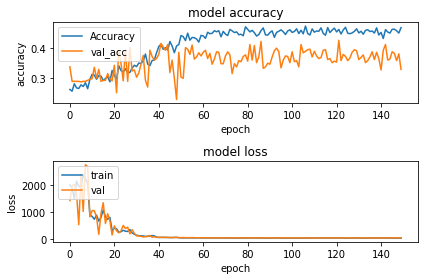

In [17]:

plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'val_acc'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.savefig('acc_loss_50.pdf')
plt.show()

In [18]:
import numpy as np

predictions = model.predict_generator(test_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [19]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

In [20]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                  precision    recall  f1-score   support

    glioma_tumor       0.26      0.36      0.31       100
meningioma_tumor       0.28      0.08      0.12       115
        no_tumor       0.25      0.49      0.33       105
 pituitary_tumor       0.55      0.15      0.23        74

        accuracy                           0.27       394
       macro avg       0.34      0.27      0.25       394
    weighted avg       0.32      0.27      0.24       394

